# Predict schizophrenia using brain anatomy

Predict schizophrenia from brain grey matter (GM). schizophrenia is associated with diffuse and complex pattern of brain atrophy. We will try to learn a predictor of the clinical status (patient with schizophrenia vs. healthy control) using GM measurements on the brain participants.

## Dataset

There are 410 samples in the training set and 103 samples in the test set.


### Input data

Voxel-based_morphometry [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry)
using [cat12](http://www.neuro.uni-jena.de/cat/) software which provides:

- Regions Of Interest (`rois`) of Grey Matter (GM) scaled for the Total
  Intracranial Volume (TIV): `[train|test]_rois.csv` 284 features.

- VBM GM 3D maps or images (`vbm3d`) of [voxels](https://en.wikipedia.org/wiki/Voxel) in the
  [MNI](https://en.wikipedia.org/wiki/Talairach_coordinates) space:
  `[train|test]_vbm.npz` contains 3D images of shapes (121, 145, 121).
  This npz contains the 3D mask and the affine transformation to MNI
  referential. Masking the brain provide *flat* 331 695 input features (voxels)
  for each participant.

By default `problem.get_[train|test]_data()` return the concatenation of 284 ROIs of
Grey Matter (GM) features with 331 695 features (voxels) within a brain mask.
Those two blocks are higly redundant.
To select only on ROIs (`rois`) features do:

```
X[:, :284]
```

To select only on (`vbm`) (voxel with the brain) features do:

```
X[:, 284:]
```

### Target

The target can be found in `[test|train]_participants.csv` files, selecting the
`age` column for regression problem.

## Evaluation metrics

[sklearn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

The main Evaluation metrics is the Root-mean-square deviation
[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). We will also
look at the R-squared
[R2](https://en.wikipedia.org/wiki/Coefficient_of_determination).


## Links


- [RAMP-workflow’s documentation](https://paris-saclay-cds.github.io/ramp-workflow/)
- [RAMP-workflow’s github](https://github.com/paris-saclay-cds/ramp-workflow)
- [RAMP Kits](https://github.com/ramp-kits)

## Installation

This starting kit requires Python and the following dependencies:

* `numpy`
* `scipy`
* `pandas`
* `scikit-learn`
* `matplolib`
* `seaborn`
* `jupyter`
* `ramp-workflow`

Therefore, we advise you to install [Anaconda
distribution](https://www.anaconda.com/download/) which include almost all
dependencies.

Only `nilearn` and `ramp-workflow` are not included by default in the Anaconda
distribution. They will be installed from the execution of the notebook.

To run a submission and the notebook you will need the dependencies listed in requirements.txt.
You can install the dependencies with the following command-line:

```
pip install -U -r requirements.txt
```

If you are using conda, we provide an environment.yml file for similar usage.

```
conda env create -f environment.yml
```

Then, you can activate the environment using:

```
conda activate brain_anatomy_schizophrenia
```

And desactivate using

```
conda deactivate
```

## Getting started

1. Download the data locally:

```
python download_data.py
```

2. Execute the jupyter notebook, from the root directory using:

```
jupyter notebook brain_anatomy_schizophrenia_starting_kit.ipynb
```

Tune your model using the starting_kit

3. Submission (Run locally)

The submissions need to be located in the `submissions` folder.
For instance for `starting_kit`, it should be located in
`submissions/submissions/starting_kit`.

Copy everything required to build your estimator in a submission file:
`submissions/submissions/starting_kit/estimator.py`.
This file must contain a function `get_estimator()`.

Run locally:

```
ramp-test --submission starting_kit
```

4. Submission on RAMP:

[Using RAMP starting-kits](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)

## Descriptive statistics

         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
           age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153


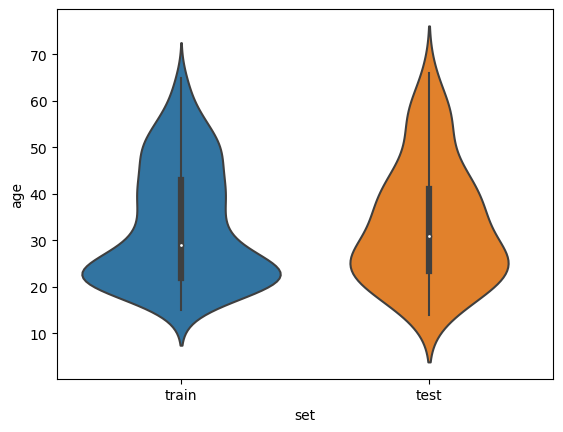

In [44]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

sns.violinplot(x="set", y="age", data=participants)
print(participants[["age", "set"]].groupby("set").describe())
print(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())

## Unsupervized analysis: Explore main sources of variabilities

Load ROIs data, `train_rois.csv` provides:

- Global volumes of "tissues": CerrebroSpinal Fluid (`CSF_Vol`), Grey (`GM_Vol`) and White Matter (`WM_Vol`) volume of participants.
- ROIs are starting at column `l3thVen_GM_Vol`. Note that `rois_train.loc[:, 'l3thVen_GM_Vol':]` matches `problem.get_train_data()[:, :284]`.

In [45]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" )).loc[:, 'l3thVen_GM_Vol':]
rois = pd.concat([rois_train, rois_test])

### PCA on ROIs: explore global effect of age

                 sum_sq     df          F        PR(>F)
diagnosis   2606.207928    1.0  29.245287  9.808873e-08
Residual   45538.013350  511.0        NaN           NaN
                 sum_sq     df          F    PR(>F)
diagnosis    791.094363    1.0  10.876419  0.001042
Residual   37167.493121  511.0        NaN       NaN


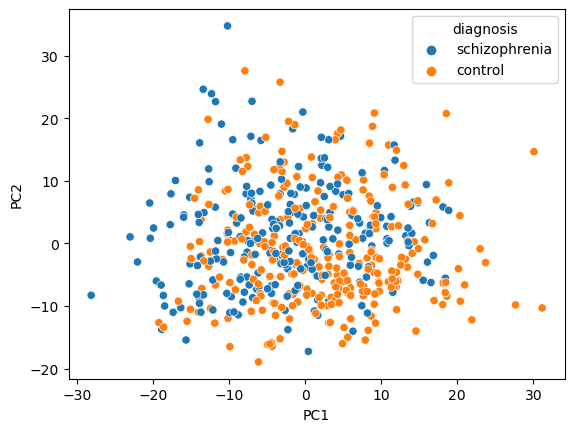

In [46]:
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

PCs = PCA(n_components=2).fit_transform(rois)
participants['PC1'], participants['PC2']  = PCs[:, 0], PCs[:, 1]

sns.scatterplot (x="PC1", y="PC2", hue="diagnosis",  data=participants)
oneway = smf.ols('PC1 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))
oneway = smf.ols('PC2 ~ diagnosis', participants).fit()
print(sm.stats.anova_lm(oneway, typ=2))

Diagnosis is associated with two first components, we expect to be abble to predict the diagnosis

## Machine learning


Import and read data

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

Load concatenated data: 284 features from ROIs and 331,695 features from VBM.

In [48]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

## Feature extractor of ROIs or voxels within the brain (VBM)

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor` 

In [49]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)

(410, 284)
(410, 331695)


## Design of predictors and their evaluation using CV and test set

The framework is evaluated with a cross-validation approach. The metrics used are the root-mean-square error (RMSE).

First we propose a simple Regression predictor based on ROIs features only:

In [50]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    ROIsFeatureExtractor(),
    MLPClassifier(random_state=1, hidden_layer_sizes=(200, 150, 100, 50, 25, )))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())


# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.2s finished


# 5CV
bACC=0.71 ROC-AUC=0.77
# Test
bACC=0.63 ROC-AUC=0.74


Then we test a simple Regression predictor based on large VBM features, using `RandomForestClassifier` that will be faster on high dimensionnal VBM data.

In [51]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(
    VBMFeatureExtractor(),
    RandomForestClassifier(random_state=1))
    
cv_results = cross_validate(estimator, X_train, y_train, scoring=['balanced_accuracy', 'roc_auc'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

print("# 5CV")
print('bACC=%.2f' % cv_results['test_balanced_accuracy'].mean(),
      'ROC-AUC=%.2f' % cv_results['test_roc_auc'].mean())

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)
score_pred_test = estimator.predict_proba(X_test)[:, 1]

bacc_test = metrics.balanced_accuracy_score(y_test, y_pred_test)
auc_test = metrics.roc_auc_score(y_test, score_pred_test)
print("# Test")
print('bACC=%.2f' % bacc_test,
      'ROC-AUC=%.2f' % auc_test)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    7.3s remaining:   11.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.5s finished


# 5CV
bACC=0.70 ROC-AUC=0.76
# Test
bACC=0.63 ROC-AUC=0.70


## Test submission locally

The submissions need to be located in the submissions folder. For instance for `starting_kit`, it should be located in `submissions/submissions/starting_kit`.

Copy everything required (the cell bellow) to build your estimator in a submission file: `submissions/submissions/starting_kit/estimator.py`. This file must contain a function `get_estimator()`:

In [52]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(
        ROIsFeatureExtractor(),
        MLPClassifier(random_state=1, hidden_layer_sizes=(200, 150, 100, 50, 25, )))

    return estimator

Run locally:
    
```
ramp-test --submission starting_kit
```

## Submission on RAMP:


Follow the instructions: [Submitting to a ramp event](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#submitting-to-a-ramp-event)

The event is [Predict schizophrenia from brain grey matter (classification)](https://ramp.studio/problems/brain_anatomy_schizophrenia)